## Identifying Fradulent Activities

* Build a machine learning model to predict the probability that the first transaction of a new user is fradulent. 

* Explain how different assumptions on the cost of false positive vs.false negative would impact the model. 

* Explain the model from the perspective of users: what kinds of users are more likely to be classified as at risk? 

* Given a model which can predict an activity is fradulent or not in **real time**, what kind of different user experience would you build based on the model output? 

In [2]:
import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
# print(plt.style.available)
plt.style.use('ggplot')
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# plt.rc('figure', figsize=(20, 20))
%matplotlib inline
# https://matplotlib.org/users/style_sheets.html

# Fixing random state for reproducibility
np.random.seed(1)


### Data Preprocess

In [5]:
# load fraud data 
data = pd.read_csv('data/Fraud/Fraud_Data.csv')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [18]:
# tell if there are repeated user id 
data['user_id'].is_unique

True

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
# ip 
ip_map = pd.read_csv('data/Fraud/IpAddress_to_Country.csv')
ip_map.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [32]:
ip_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [34]:
data.iloc[1, ]['ip_address']

350311387.865908

In [105]:
a = [1, 2, 3]
try:
    print(a[4])
except IndexError:
    print('t')

t


In [82]:
ip_map[(ip_map['lower_bound_ip_address'] <= 350311387.865908) &
                          (ip_map['upper_bound_ip_address'] >= 350311387.865908)]['country']

1017    United States
Name: country, dtype: object

In [114]:
# merge the two data sets 

# find the country of each user id 
def merge_data(data, ip_map):
    countries = []
    for i in range(len(data)):
        cur_ip = data.iloc[i, ]['ip_address']
#         print(cur_ip)
        # look up country in ip_map 
        try:
            country_i = ip_map[(ip_map['lower_bound_ip_address'] <= cur_ip) & 
                          (ip_map['upper_bound_ip_address'] >= cur_ip)]['country'].values[0]
#             print(country_i)
        except IndexError:
            country_i = None
        countries.append(country_i)
#         if i % 10000 == 0:
#             print(i)
    data['country'] = countries 
    
    return data 
        
        


In [115]:
all_data = merge_data(data, ip_map)

In [116]:
all_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [117]:
# save merged data 
all_data.to_csv('data/Fraud/all_data.csv')

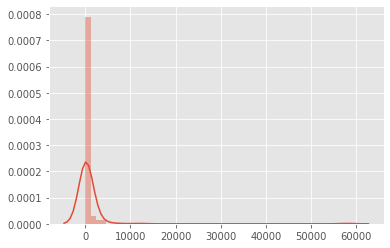

In [128]:
# check users by country 
grouped_country = all_data['country'].value_counts()
sns.distplot(grouped_country.values)

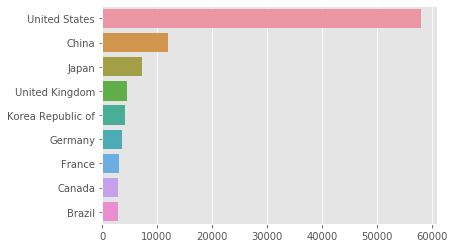

In [126]:
# check users by country 
grouped_country_high = grouped_country[grouped_country > 2000]
sns.barplot(grouped_country_high.values, grouped_country_high.index)

### Feature Engineering

Create ne powerful variables with current data.